In [98]:
import networkx as nx
import matplotlib.pyplot as plt

In [110]:
"""Modularity matrix of graphs.
"""
#    Copyright (C) 2004-2015 by
#    Aric Hagberg <hagberg@lanl.gov>
#    Dan Schult <dschult@colgate.edu>
#    Pieter Swart <swart@lanl.gov>
#    All rights reserved.
#    BSD license.
from __future__ import division
import networkx as nx
from networkx.utils import not_implemented_for
__author__ = "\n".join(['Aric Hagberg <aric.hagberg@gmail.com>',
                        'Pieter Swart (swart@lanl.gov)',
                        'Dan Schult (dschult@colgate.edu)',
                        'Jean-Gabriel Young (Jean.gabriel.young@gmail.com)'])
__all__ = ['modularity_matrix', 'directed_modularity_matrix']


@not_implemented_for('directed')
@not_implemented_for('multigraph')
def modularity_matrix(G, nodelist=None):
    """Return the modularity matrix of G.

    The modularity matrix is the matrix B = A - <A>, where A is the adjacency
    matrix and <A> is the average adjacency matrix, assuming that the graph
    is described by the configuration model.

    More specifically, the element B_ij of B is defined as
        A_ij - k_i k_j/m
    where k_i(in) is the degree of node i, and were m is the number of edges
    in the graph.

    Parameters
    ----------
    G : Graph
       A NetworkX graph

    nodelist : list, optional
       The rows and columns are ordered according to the nodes in nodelist.
       If nodelist is None, then the ordering is produced by G.nodes().

    Returns
    -------
    B : Numpy matrix
      The modularity matrix of G.

    Examples
    --------
    >>> import networkx as nx
    >>> k =[3, 2, 2, 1, 0]
    >>> G = nx.havel_hakimi_graph(k)
    >>> B = nx.modularity_matrix(G)


    See Also
    --------
    to_numpy_matrix
    adjacency_matrix
    laplacian_matrix
    directed_modularity_matrix

    References
    ----------
    .. [1] M. E. J. Newman, "Modularity and community structure in networks",
       Proc. Natl. Acad. Sci. USA, vol. 103, pp. 8577-8582, 2006.
    """
    if nodelist is None:
        nodelist = G.nodes()
    A = nx.to_scipy_sparse_matrix(G, nodelist=nodelist, format='csr')
    k = A.sum(axis=1)
    m = G.number_of_edges()
    # Expected adjacency matrix
    X = k * k.transpose() / (2 * m)
    return A - X


@not_implemented_for('undirected')
@not_implemented_for('multigraph')
def directed_modularity_matrix(G, nodelist=None):
    """Return the directed modularity matrix of G.

    The modularity matrix is the matrix B = A - <A>, where A is the adjacency
    matrix and <A> is the expected adjacency matrix, assuming that the graph
    is described by the configuration model.

    More specifically, the element B_ij of B is defined as
        B_ij = A_ij - k_i(out) k_j(in)/m
    where k_i(in) is the in degree of node i, and k_j(out) is the out degree
    of node j, with m the number of edges in the graph.

    Parameters
    ----------
    G : DiGraph
       A NetworkX DiGraph

    nodelist : list, optional
       The rows and columns are ordered according to the nodes in nodelist.
       If nodelist is None, then the ordering is produced by G.nodes().

    Returns
    -------
    B : Numpy matrix
      The modularity matrix of G.

    Examples
    --------
    >>> import networkx as nx
    >>> G = nx.DiGraph()
    >>> G.add_edges_from(((1,2), (1,3), (3,1), (3,2), (3,5), (4,5), (4,6),
    ...                   (5,4), (5,6), (6,4)))
    >>> B = nx.directed_modularity_matrix(G)


    Notes
    -----
    NetworkX defines the element A_ij of the adjacency matrix as 1 if there
    is a link going from node i to node j. Leicht and Newman use the opposite
    definition. This explains the different expression for B_ij.

    See Also
    --------
    to_numpy_matrix
    adjacency_matrix
    laplacian_matrix
    modularity_matrix

    References
    ----------
    .. [1] E. A. Leicht, M. E. J. Newman, 
       "Community structure in directed networks",
        Phys. Rev Lett., vol. 100, no. 11, p. 118703, 2008.
    """
    if nodelist is None:
        nodelist = G.nodes()
    A = nx.to_scipy_sparse_matrix(G, nodelist=nodelist, format='csr')
    k_in = A.sum(axis=0)
    k_out = A.sum(axis=1)
    m = G.number_of_edges()
    # Expected adjacency matrix
    X = k_out * k_in / m
    return A - X


# fixture for nose tests
def setup_module(module):
    from nose import SkipTest
    try:
        import numpy
        import scipy
    except:
        raise SkipTest("NumPy not available")

In [111]:
# -*- coding: utf-8 -*-
# centrality.py - functions for computing communities using centrality notions
#
# Copyright 2015, 2016 NetworkX developers.
#
# This file is part of NetworkX.
#
# NetworkX is distributed under a BSD license; see LICENSE.txt for more
# information.
"""Functions for computing communities based on centrality notions."""

import networkx as nx

def girvan_newman(G, most_valuable_edge=None):

    # If the graph is already empty, simply return its connected
    # components.
    if G.number_of_edges() == 0:
        yield tuple(nx.connected_components(G))
        return
    # If no function is provided for computing the most valuable edge,
    # use the edge betweenness centrality.
    if most_valuable_edge is None:
        def most_valuable_edge(G):
            """Returns the edge with the highest betweenness centrality
            in the graph `G`.

            """
            # We have guaranteed that the graph is non-empty, so this
            # dictionary will never be empty.
            betweenness = nx.edge_betweenness_centrality(G)
            return max(betweenness, key=betweenness.get)
    # The copy of G here must include the edge weight data.
    g = G.copy().to_undirected()
    # Self-loops must be removed because their removal has no effect on
    # the connected components of the graph.
    g.remove_edges_from(g.selfloop_edges())
    while g.number_of_edges() > 0:
        yield _without_most_central_edges(g, most_valuable_edge)



def _without_most_central_edges(G, most_valuable_edge):
    """Returns the connected components of the graph that results from
    repeatedly removing the most "valuable" edge in the graph.

    `G` must be a non-empty graph. This function modifies the graph `G`
    in-place; that is, it removes edges on the graph `G`.

    `most_valuable_edge` is a function that takes the graph `G` as input
    (or a subgraph with one or more edges of `G` removed) and returns an
    edge. That edge will be removed and this process will be repeated
    until the number of connected components in the graph increases.

    """
    original_num_components = nx.number_connected_components(G)
    num_new_components = original_num_components
    while num_new_components <= original_num_components:
        edge = most_valuable_edge(G)
        G.remove_edge(*edge)
        new_components = tuple(nx.connected_components(G))
        num_new_components = len(new_components)
    return new_components

### Political blogs data

In [ ]:
#import gml file, sepparate G1 (websites graph) and G2 (liberal vs conservative graph)
pol_blog = '/home/frank/Dropbox/school/Networks/data/pol_blog/polblogs.gml'
G1 = nx.read_gml(pol_blog)
pos1 = nx.spring_layout(G1)

lib_nodes = G1.subgraph( [n for n,d in G1.node.items() if d['value'] == 0])
cons_nodes = G1.subgraph( [n for n,d in G1.node.items() if d['value'] == 1])
nx.draw_networkx_nodes(lib_nodes, pos1,node_color='r', alpha = 0.3)
nx.draw_networkx_nodes(cons_nodes, pos1,node_color='b', alpha = 0.3)
nx.draw_networkx_edges(G1, pos1, alpha = 0.3)
plt.rcParams["figure.figsize"] = [20,20]
plt.title("Political blogs network", alpha = 0.3)
plt.plot()
plt.show()

In [218]:
pol_blog = '/home/frank/Dropbox/school/Networks/data/pol_blog/polblogs.gml'
G1 = nx.read_gml(pol_blog)

In [219]:
#Run girvan_newman and identify communities
comp = girvan_newman(G)
groupings = tuple(c for c in next(comp))

In [225]:
len(groupings)

270

Girvan Newman methdo has identified 270 communities in this set, with the total of 1490 nodes present(urls). Looking at the previous graph, where we cannot easily identify communities due to large mixture liberal and conservative blogs interconnected. 270 modules is significantly larger number of groupings and should be investigated with additional data about main geographical and demographical features of each website. 

In [ ]:
#Function to find largest eigenvalues.

import numpy as np
#from time import clock
from scipy.linalg import eigh as largest_eigh
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh

#np.set_printoptions(suppress=True)
#np.random.seed(0)
#N=5000
#k=10
#X = np.random.random((N,N)) - 0.5
#X = np.dot(X, X.T) #create a symmetric matrix

# Benchmark the dense routine
#start = clock()
evals_large, evecs_large = largest_eigh(X, eigvals=(N-k,N-1))
#elapsed = (clock() - start)
#print "eigh elapsed time: ", elapsed

# Benchmark the sparse routine
#start = clock()
evals_large_sparse, evecs_large_sparse = largest_eigsh(X, k, which='LM')
#elapsed = (clock() - start)
#print "eigsh elapsed time: ", elapsed

In [ ]:
mod_1 = modularity_matrix(G1)

#### set2

In [198]:
import numpy as np
file2 = "/home/frank/Dropbox/school/Networks/data/Social_networks of pos_sentiment/prisoninter_st.txt"

In [215]:
G2_df = np.loadtxt(file2, delimiter=" ")
#columns = ['source','target','weight']

source = list(G2_df[:,0])
target = list(G2_df[:,1])
nodes = set(list(G2_df[:,1]))
edges = zip(source,target)

G2 = nx.Graph()
G2.add_nodes_from(nodes)
G2.add_edges_from(edges)

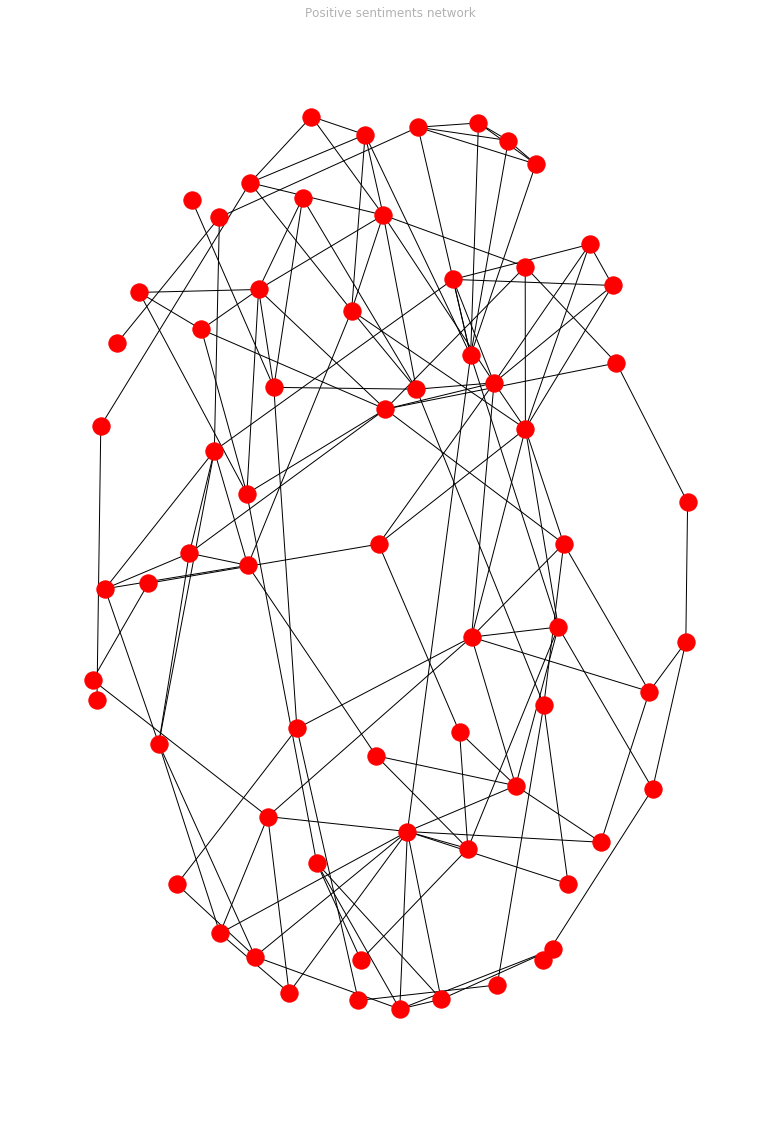

In [204]:
nx.draw(G2)
plt.title("Positive sentiments network", alpha = 0.3)
plt.plot()
plt.show()

In [226]:
compw = girvan_newman(G2)
groupings2 = tuple(c for c in next(compw))

In [227]:
len(groupings2)

2

Due to limited number of nodes, resolution limit hasn't been reached and no meaningful information can be obtained from the glande. However, 2 groups have been identified. 

In [ ]:
mod_1 = modularity_matrix(G2)
